In [1]:
%reload_ext autoreload
%autoreload 2
import tie.dbutils as db
import tie.utils as qa
import pandas as pd
from scipy.io import savemat, loadmat
import json
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import DivergingNorm, TwoSlopeNorm, Normalize
from statsmodels.stats.multitest import fdrcorrection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [2]:
rc('font', **{'family':'sans-serif',
              'sans-serif':['Helvetica']})
FONT_SIZE = 25
params = {'axes.labelsize': FONT_SIZE,
          'axes.titlesize': FONT_SIZE, 
          'legend.fontsize': FONT_SIZE, 
          'xtick.labelsize': FONT_SIZE, 
          'ytick.labelsize': FONT_SIZE}
matplotlib.rcParams.update(params)

ORDER = [0, 2, 3, 1] # Full, Social, Transition, Launcher
version = 'v6_IRLS'

In [3]:
study_id_1 = 'aef31aeb7b4d9dde43779738b42be454dc0ede19'  # -- Leiden Uni Age Study
study_id_2 = "aef333cc3597c660421091c3f4d8ecb4e809de19" # -- Leiden Uni 
study_id_3 = "aef34cc4d24c162f4f87becb74515e392560de19" # -- COOLS

In [4]:
raw_query = '''SELECT SDV."partId", SDV."devicePartId" as "devPartId", tde."deviceInfo", tde."id", "modified", "created"
from "StudyDetailsView" SDV
JOIN "TapDevice" tde on SDV."tapDeviceId" = tde."id"
where SDV."studyId"=? or SDV."studyId"=? or SDV."studyId"=?;'''
df = db.raw_query(raw_query, params=[study_id_1, study_id_2, study_id_3])
df['days'] = (df['modified'] - df['created'] ) / 1000 / 3600 / 24
df.head(2)

,partId,devPartId,deviceInfo,id,modified,created,days
0,138efc8063d3729040fb817663edae7c94b328eb,8sd8fe9d359d9d654c7fafb8efc55def56dc12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""On...",0032fe57-d169-4a43-919d-bd415de40a8e,1592896678076,1587754338923,59.517814
1,138ee12eb779c05544cba2bfee03ecef1feb28eb,8sd8a4534d5635cb4936a9d848e019dfa68f12ka,"{""androidVersion"":""9"",""deviceManufacturer"":""mo...",00431dfe-0245-47fe-879e-e641daa55dc9,1568805227286,1565089811972,43.002492


In [6]:
info_age = pd.read_csv('../../../only_info_figure_1.csv')
full_info = info_age.merge(df, on='partId').dropna().drop_duplicates("partId")
full_info.head(2)

,partId,age,n_taps,gender,devPartId,deviceInfo,id,modified,created,days
0,138ee6d165fa06954ba1bed56719415b12dd28eb,60,2645834,2,8sd8474d8c7c03ef46c5b3acf034d689257c12ka,"{""androidVersion"":""11"",""deviceManufacturer"":""s...",9feae480-d169-486e-b00d-02fcf4585d44,1625757992616,1593108388846,377.888933
2,138ee5b320ea6ee948d2a3bf2f8c55ffecd428eb,23,339201,2,8sd8762e35b65efa465fb90c7d2b7f5b5ad012ka,"{""androidVersion"":""10"",""deviceManufacturer"":""s...",f23fd700-1d72-4db0-a584-e7f979ad6d92,1620035028533,1593642422788,305.469974


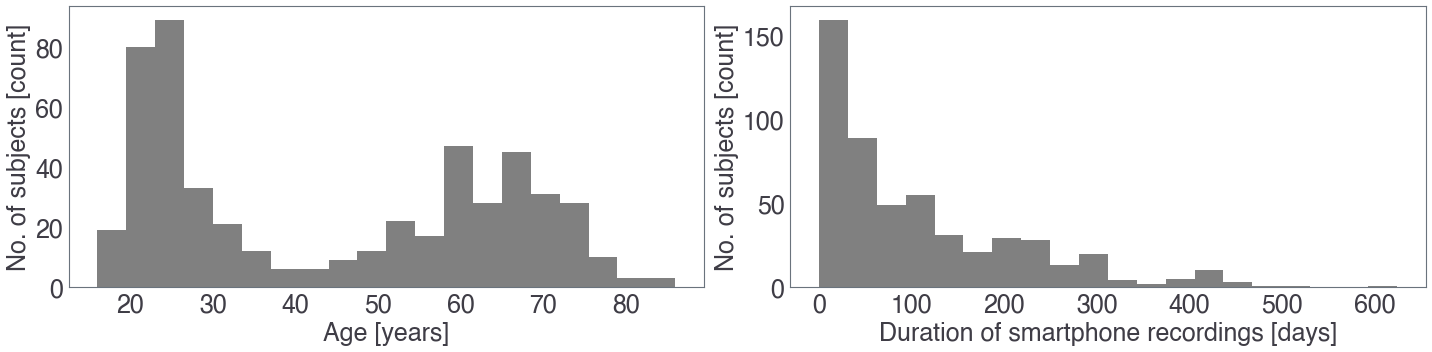

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

## AGE
full_info["age"].hist(bins=20, ax=ax[0], color='grey')

ax[0].set_xlabel("Age [years]")
ax[0].set_ylabel("No. of subjects [count]")
ax[0].grid(False)

## DAYS
full_info["days"].hist(bins=20, ax=ax[1], color='grey')

ax[1].set_xlabel("Duration of smartphone recordings [days]")
ax[1].set_ylabel("No. of subjects [count]")
ax[1].grid(False)

plt.tight_layout()
plt.savefig('figure_1_panel_a.pdf', transparent=True)

In [8]:
df_fig1pana = pd.DataFrame(columns={'type', 'N', 'min', 'max', '25th', '50th', '75th'})
df_fig1pana['type'] = ['female', 'age', 'days']
df_fig1pana['N'] = [len(full_info[full_info['gender'] == 2]), len(full_info), len(full_info)]
df_fig1pana['min'] = [np.nan, min(full_info['age']), min(full_info['days'])]
df_fig1pana['max'] = [np.nan, max(full_info['age']), max(full_info['days'])]
df_fig1pana['25th'] = [np.nan, np.percentile(full_info['age'], 25), np.percentile(full_info['days'], 25)]
df_fig1pana['50th'] = [np.nan, np.percentile(full_info['age'], 50), np.percentile(full_info['days'], 50)]
df_fig1pana['75th'] = [np.nan, np.percentile(full_info['age'], 75), np.percentile(full_info['days'], 75)]
df_fig1pana.to_csv('figure_1_panel_a.csv', index=False)
df_fig1pana

,max,min,type,25th,50th,75th,N
0,NaN,NaN,female,NaN,NaN,NaN,319
1,86.000000,16.0,age,23.000000,41.000000,63.000000,521
2,623.510652,0.0,days,20.105228,72.002768,162.985033,521


# Panel b

In [9]:
allJIDs = loadmat('ex_all_jids.mat')

In [10]:
fullJID = allJIDs['fullJID']
socialJID = allJIDs['socialJID']
transitionJID = allJIDs['transitionJID']
print(fullJID.shape)

(50, 50)


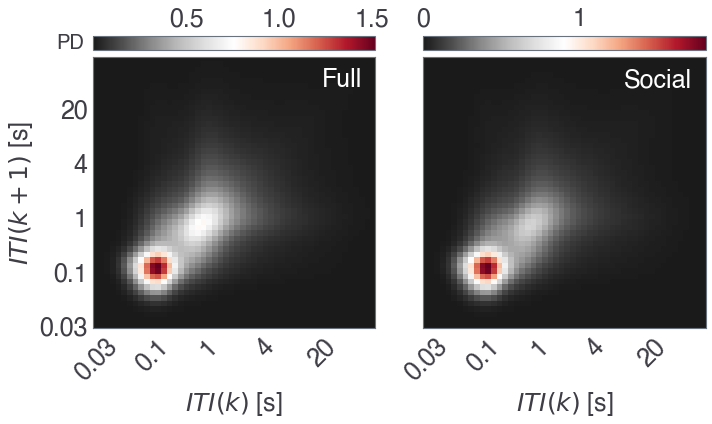

In [13]:
# This is over 166 days
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, (_JID, _title, x_bias) in enumerate(zip([fullJID, socialJID], 
                             ['Full', 'Social'],
                             [40, 35])):
    im = ax[i].imshow(_JID.T, aspect='auto', cmap='RdGy_r')
    ax[i].text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    ax[i].invert_yaxis()
    ax[i].set_xticks(ticks)
    ax[i].set_xticklabels(labels)
    ax[i].xaxis.set_tick_params(rotation=45)
    ax[i].set_yticks(ticks)
    ax[i].set_yticklabels(labels)
    ax[i].set_xlabel(r'$ITI(k)$ [s]')
    ax[i].grid(False)
    divider = make_axes_locatable(ax[i])
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
ax[0].set_ylabel(r'$ITI(k + 1)$ [s]');
ax[0].text(-7, 51, 'PD', size=20)
plt.tight_layout()
plt.savefig('figure_1_panel_b.pdf', transparent=True)

# Supplementary b.i.

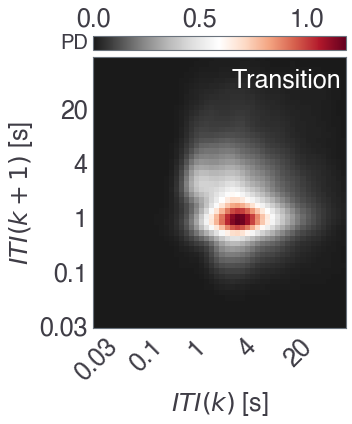

In [17]:
# This is over 166 days
fig, ax = plt.subplots(1, 1, figsize=(5, 6), sharey=True)

labels = ['0.03', '0.1', '1', '4', '20']
ticks = np.arange(50)[::10]

for i, (_JID, _title, x_bias) in enumerate(zip([transitionJID], 
                             ['Transition'],
                             [27])):
    im = ax.imshow(_JID.T, aspect='auto', cmap='RdGy_r')
    ax.text(x_bias, 44, f"{_title}", fontsize=25, color='white')
    ax.invert_yaxis()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    ax.set_xlabel(r'$ITI(k)$ [s]')
    ax.grid(False)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=.1, pack_start=False)
    fig.add_axes(cax)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position('top')
ax.set_ylabel(r'$ITI(k + 1)$ [s]');
ax.text(-7, 51, 'PD', size=20)
plt.tight_layout()
plt.savefig('figure_supplementary_b_i.pdf', transparent=True)